# Single ancient sample

As in [Skoglund et al., 2014](https://academic.oup.com/mbe/article/31/9/2516/2925787):
- populations A and B diverged 20000 years ago
- Ne = 10000
- 10 modern individuals sampled in each population
- a single individual sampled 18000 years ago in lineage leading to population B

## Constant effective population size

In [2]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def run_sim(num_replicates, nbA, nbM, samples, population_configurations, demographic_events):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 2, samples = samples,
                                  mutation_rate=5e-6, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events = demographic_events)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM*2+nbA,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [4]:
def plot_pca_coords(coords, model, pc1, pc2, ax, ages, nbM, nbA):
    i = 0
    # modern samples
    for p in [pops[0], pops[1]]:
        x = coords[i:i+nbM, pc1]
        y = coords[i:i+nbM, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=p, color=type_color[p], markersize=6, mec='k', mew=.5)
        i += nbM
    # ancient sample
    x = coords[i:i+nbA, pc1]
    y = coords[i:i+nbA, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label=pops[2],
            color=type_color[pops[2]], markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

In [5]:
def plot_PC_maps(coords, model, pc, ax, nbM, nbA):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    # modern samples
    for p in [pops[0], pops[1]]:
        y = coords[i:i+nbM, pc]
        x = np.zeros(len(y))
        ax.plot(x, y, marker='o', linestyle=' ', label=p, color=type_color[p], markersize=6, mec='k', mew=.5)
        i += nbM
    # ancient samples
    y = coords[i:i+nbA, pc]
    ax.plot(18000, y, marker='o', linestyle=' ', label=pops[2], color=type_color[pops[2]], markersize=6, mec='k', mew=.5)
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Age (years b.p.)')

In [6]:
Ne = 10000
nbM = 10
nbA = 1

samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] + [msprime.Sample(1,0) for i in np.arange(2*nbM)]
samples += [msprime.Sample(1,720) for i in np.arange(2)]

population_configurations = [
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
        msprime.MassMigration(800, source=1, dest=0)]

dp = msprime.DemographyDebugger(           
    population_configurations=population_configurations,
    demographic_events=demographic_events)
dp.print_history()

Epoch: 0 -- 800.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 800.0
   - Mass migration: lineages move from 1 to 0 with probability 1.0
Epoch: 800.0 -- inf generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    



In [11]:
g = allel.model.GenotypeArray(run_sim(50000, nbA, nbM, samples, population_configurations, demographic_events))
g

<GenotypeArray shape=(93315, 21, 2) dtype=int8>
0/0 1/1 1/1 0/1 0/1 ... 0/0 0/0 0/0 0/1 0/0
1/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 1/1 1/1 1/1 0/1 ... 1/1 0/0 1/1 1/1 1/0
...
1/0 0/0 0/0 0/0 1/0 ... 0/0 0/1 0/0 1/0 1/0
1/1 1/1 1/1 1/1 1/0 ... 0/0 1/0 0/0 0/0 1/1
0/0 0/0 0/0 0/0 0/0 ... 1/1 0/1 1/1 1/1 0/0

In [12]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn)
coords.shape

(21, 10)

In [13]:
pops = ['pop A', 'pop B', 'ancient, pop B']
palette = sns.color_palette("hls", len(pops))
type_color = {
    'pop A': palette[0],
    'pop B': palette[1],
    'ancient, pop B': palette[2]
}

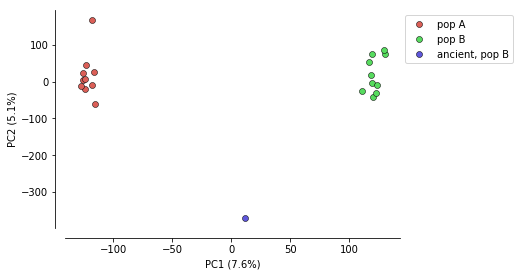

In [14]:
fig, ax = plt.subplots()
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax, pops, nbM, nbA)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

PC1 captures the spatial differenciation between population A and B whereas PC2 captures the temporal differenciation between modern and ancient samples.<br>
The ancient sample appears closer to population B.

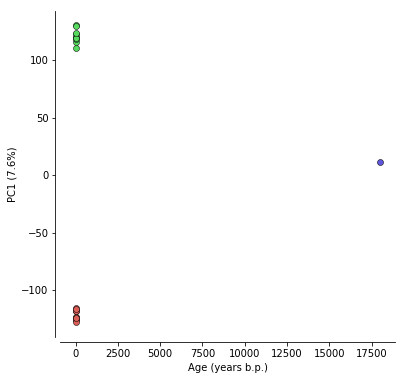

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
plot_PC_maps(coords, model, 0, ax, nbM, nbA)

## 10-fold population size reduction postdating the ancient individual

In [16]:
Ne = 1000
nbM = 10
nbA = 1

samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] + [msprime.Sample(1,0) for i in np.arange(2*nbM)]
samples += [msprime.Sample(1,720) for i in np.arange(2)]

population_configurations = [
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
    msprime.PopulationParametersChange(time=0, initial_size=Ne*10, population=0),
    msprime.PopulationParametersChange(time=600, initial_size=Ne*10),
    msprime.MassMigration(800, source=1, dest=0)]

dp = msprime.DemographyDebugger(           
    population_configurations=population_configurations,
    demographic_events=demographic_events)
dp.print_history()

Events @ generation 0
   - Population parameter change for 0: initial_size -> 10000 
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+03    1e+03               0 |     0        0    
1 |  1e+03    1e+03               0 |     0        0    

Epoch: 0.0 -- 600.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+03    1e+03               0 |     0        0    

Events @ generation 600.0
   - Population parameter change for -1: initial_size -> 10000 
Epoch: 600.0 -- 800.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 800.0
   - Mass migratio

In [17]:
g = allel.model.GenotypeArray(run_sim(50000, nbA, nbM, samples, population_configurations, demographic_events))
g

<GenotypeArray shape=(83036, 21, 2) dtype=int8>
0/0 0/0 0/0 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/1 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
1/1 0/1 1/1 1/1 0/1 ... 0/0 0/0 0/0 0/0 0/1
...
0/0 0/0 0/0 0/0 0/1 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/1 1/0 1/0 1/0 ... 1/0 0/1 0/1 0/0 0/1

In [18]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn)
coords.shape

(21, 10)

In [19]:
pops = ['pop A', 'pop B', 'ancient, pop B']
palette = sns.color_palette("hls", len(pops))
type_color = {
    'pop A': palette[0],
    'pop B': palette[1],
    'ancient, pop B': palette[2]
}

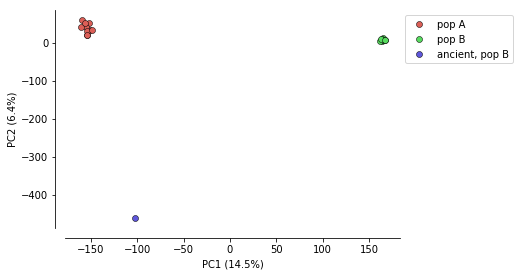

In [20]:
fig, ax = plt.subplots()
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax, pops, nbM, nbA)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

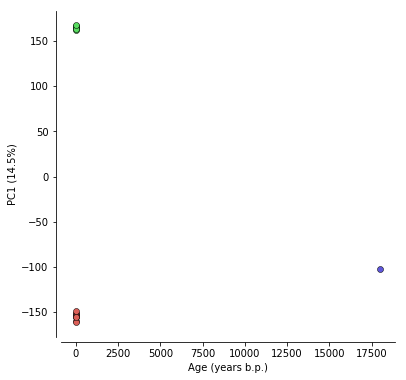

In [21]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
plot_PC_maps(coords, model, 0, ax, nbM, nbA)

The ancient sample clusters closer to population A, despite the fact that the ancient individual was sampled the population that is ancestral to the extant sample from population B.<br>
On the coalescent scale, less time has passed between the ancient sample and samples from population A.

**If the demographic history is unknown, one could possibly mistakenly conclude that the ancient sample shares more recent genetic history with population A.** 